In [129]:
import os
import gc
import cv2
import math
import copy
import time
import random
from scipy.stats import gaussian_kde
import numpy as np
# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
from scipy.integrate import cumtrapz
# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import pickle
from sklearn.metrics import f1_score,roc_auc_score


import timm
from timm.models.efficientnet import *

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict


import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage

import glob

In [ ]:
train_ct_all_pd = pd.read_csv('/ssd2/ming/2024COVID/chih_4_fold_covid_train_df.csv')[['path','slice_name']]
train_ct_all_pd['full_path'] = train_ct_all_pd['path']+'/'+train_ct_all_pd['slice_name']
train_ct_all_list = train_ct_all_pd.full_path.values.tolist()
valid_ct_all_pd = pd.read_csv('/ssd2/ming/2024COVID/chih_4_fold_covid_valid_df.csv')[['path','slice_name']]
valid_ct_all_pd['full_path'] = valid_ct_all_pd['path']+'/'+valid_ct_all_pd['slice_name']
valid_ct_all_list = valid_ct_all_pd.full_path.values.tolist()
print(train_ct_all_pd.shape, valid_ct_all_pd.shape)

In [ ]:
train_area=[]
for path in tqdm(train_ct_all_list):
    img = cv2.imread(path)
    img2=ndimage.minimum_filter(img,5)
    img_b=np.where(img2<100,0,255)
    mask=scipy.ndimage.binary_fill_holes(img_b[:,:,0])
    mask_=mask*255
    aaa=mask_-img_b[:,:,0]
    train_area.append(aaa.sum()/255)
    

In [17]:
train_ct_all_list

#modified_list = ['/train_pure_crop_challenge' if '/train' in item else item for item in train_ct_all_list]
modified_list = [item.replace('train','train_pure_crop_challenge') for item in train_ct_all_list]
train_area_df=pd.DataFrame((zip(modified_list, train_area)), columns = ['path', 'area'])
train_area_df.to_csv("/ssd2/ming/2024COVID/train_area_df1_challenge.csv", index=False, encoding='utf-8-sig')
train_area_df
print(train_area_df.shape)

(76260, 2)


In [ ]:
valid_area=[]
for path in tqdm(valid_ct_all_list):
    img = cv2.imread(path)
    img2=ndimage.minimum_filter(img,5)
    img_b=np.where(img2<100,0,255)
    mask=scipy.ndimage.binary_fill_holes(img_b[:,:,0])
    mask_=mask*255
    aaa=mask_-img_b[:,:,0]
    valid_area.append(aaa.sum()/255)
    

In [ ]:
valid_ct_all_list

#modified_list = ['/train_pure_crop_challenge' if '/train' in item else item for item in train_ct_all_list]
modified_list = [item.replace('valid','valid_pure_crop_challenge') for item in valid_ct_all_list]
valid_area_df=pd.DataFrame((zip(modified_list, valid_area)), columns = ['path', 'area'])
valid_area_df.to_csv("/ssd2/ming/2024COVID/valid_area_df1_challenge.csv", index=False, encoding='utf-8-sig')
valid_area_df
print(valid_area_df.shape)

In [3]:
train_area_df=pd.read_csv("/ssd2/ming/2024COVID/train_area_df1_challenge.csv")
valid_area_df=pd.read_csv("/ssd2/ming/2024COVID/valid_area_df1_challenge.csv")
print(train_area_df.shape, valid_area_df.shape)

(385631, 2) (90690, 2)


In [6]:
train_area_df["ct_path"]=train_area_df["path"].apply(lambda x: "/".join(x.split("/")[:-1]))
valid_area_df["ct_path"]=valid_area_df["path"].apply(lambda x: "/".join(x.split("/")[:-1]))

train_area_df["ct_slice"]=train_area_df["path"].apply(lambda x: int(x.split("/")[-1].split(".")[0]))
valid_area_df["ct_slice"]=valid_area_df["path"].apply(lambda x: int(x.split("/")[-1].split(".")[0]))

train_area_df.sort_values(by=['ct_path', 'ct_slice'], inplace=True)
valid_area_df.sort_values(by=['ct_path', 'ct_slice'], inplace=True)

In [7]:
def sum_max(a,w=0.4):
    l=len(a)
    k=int(np.ceil(l*w))
    d=0
    tmp_max=0
    # print(l, k)
    for i in range(l-k+1):
        if np.sum(a[i:i+k])>tmp_max:
            tmp_max=np.sum(a[i:i+k])
            d=i
    return d,d+k

def remove_elements(arr):
    # Determine the action based on the array length
    if len(arr) < 60:
        # Remove the first 20 and the last 20 elements
        return arr[20:-20]
    else:
        # Remove the last 40 and the first 20 elements
        return arr[20:-40]
def sum_max_with_adjustment(a, w=0.4):
    # Adjust the array based on its length
    if len(a) < 60:
        # Remove the first 20 and the last 20 elements
        adjusted_a = a[20:-20]
    else:
        # Remove the last 40 and the first 20 elements
        adjusted_a = a[20:-45]
    
    l = len(adjusted_a)
    k = int(np.ceil(l * w))
    d = 0
    tmp_max = 0
    
    for i in range(l - k + 1):
        current_sum = np.sum(adjusted_a[i:i+k])
        if current_sum > tmp_max:
            tmp_max = current_sum
            d = i
    
    # Adjust d and d+k back to the original array's index space
    if len(a) < 60:
        d += 20  # Adjust index if the array was shorter than 60
    else:
        d += 20  # Always adjust by 20 because we always remove the first 20 elements
    
    return d, d + k    

In [175]:
ct_path_list=train_area_df["ct_path"].unique()
train_dic={}
for i in tqdm(range(len(ct_path_list))):
    tmp_df=train_area_df[train_area_df["ct_path"]==ct_path_list[i]].reset_index(drop=True)
    tmp_df=train_area_df[train_area_df["ct_path"]==ct_path_list[i]].reset_index(drop=True)
    #train_dic[ct_path_list[i]]=list(sum_max_with_adjustment(tmp_df["area"].values,0.5))
    #train_dic[ct_path_list[i]]=[list(sum_max_with_adjustment(tmp_df["area"].values,0.5)),len(tmp_df)]
    d1,d2=list(sum_max_with_adjustment(tmp_df["area"].values,0.5))
    train_dic[ct_path_list[i]]=[d1,d2]
    k=[]
    for j in range(len(tmp_df['area'][d1:d2])):
        k.append(tmp_df['area'][j+d1])
    train_dic[ct_path_list[i]].append(k)
    #print(train_dic[ct_path_list[i]][2],d1,d2)
    if d2-d1>=8:
        train_dic[ct_path_list[i]].append(sorted(kd_sampling(train_dic[ct_path_list[i]][2],d1,4,8)))
    elif (d2-d1)>=2 and (d2-d1)<8:
        train_dic[ct_path_list[i]].append(sorted([random.randint(d1, d2-1) for _ in range(8)]))
    else:
        train_dic[ct_path_list[i]].append([d1 for _ in range(8)])

100%|██████████| 1358/1358 [01:57<00:00, 11.61it/s]


In [177]:
for i in range(len(train_dic)):
    print(train_dic[ct_path_list[i]][3],train_dic[ct_path_list[i]][0],train_dic[ct_path_list[i]][1])

[143, 146, 168, 195, 205, 208, 251, 269] 123 276
[168, 188, 191, 191, 244, 252, 253, 267] 138 314
[21, 22, 23, 25, 26, 28, 30] 21 31
[125, 174, 175, 205, 209, 274, 308, 316] 90 319
[20, 21, 22, 24, 25, 26, 27] 20 28
[151, 157, 173, 190, 206, 265, 268, 276] 124 284
[27, 28, 29, 30, 31, 33, 34] 27 36
[25, 25, 25, 26, 27, 27, 27, 27] 25 31
[21, 21, 21, 22, 22, 23, 24, 25] 20 26
[101, 114, 137, 169, 194, 197, 205, 230] 99 238
[89, 103, 132, 133, 175, 186, 203, 208] 83 223
[20, 20, 20, 20, 20, 20, 20, 20] 20 21
[97, 109, 111, 124, 150, 157, 172, 177] 69 188
[126, 136, 148, 181, 211, 218, 224, 274] 120 276
[23, 24, 25, 26, 27, 28, 28, 28] 23 29
[103, 129, 161, 172, 190, 205, 211, 218] 85 225
[20, 20, 21, 21, 21, 23, 23, 23] 20 26
[117, 126, 129, 137, 167, 207, 216, 249] 100 280
[25, 25, 25, 26, 28, 29, 29, 29] 25 30
[102, 130, 180, 201, 206, 246, 252, 254] 70 268
[270, 313, 367, 381, 390, 410, 438, 504] 264 509
[147, 177, 184, 207, 237, 241, 292, 293] 131 294
[94, 120, 137, 158, 172, 181, 18

In [179]:
ct_path_list=valid_area_df["ct_path"].unique()
valid_dic={}
for i in tqdm(range(len(ct_path_list))):
    tmp_df=valid_area_df[valid_area_df["ct_path"]==ct_path_list[i]].reset_index(drop=True)
    #valid_dic[ct_path_list[i]]=list(sum_max_with_adjustment(tmp_df["area"].values,0.5))
    #valid_dic[ct_path_list[i]]=[list(sum_max_with_adjustment(tmp_df["area"].values,0.5)),len(tmp_df)]
    d1,d2=list(sum_max_with_adjustment(tmp_df["area"].values,0.5))
    valid_dic[ct_path_list[i]]=[d1,d2]
    k=[]
    for j in range(len(tmp_df['area'][d1:d2])):
        k.append(tmp_df['area'][j+d1])
    valid_dic[ct_path_list[i]].append(k)
    #print(valid_dic[ct_path_list[i]][2],d1,d2)
    if d2-d1>=8:
        valid_dic[ct_path_list[i]].append(sorted(kd_sampling(valid_dic[ct_path_list[i]][2],d1,4,8)))
    elif (d2-d1)>=2 and (d2-d1)<8:
        valid_dic[ct_path_list[i]].append(sorted([random.randint(d1, d2-1) for _ in range(8)]))
    else:
        valid_dic[ct_path_list[i]].append([d1 for _ in range(8)])

    

  0%|          | 0/326 [00:00<?, ?it/s]

100%|██████████| 326/326 [00:03<00:00, 86.00it/s]


In [180]:
for i in range(len(valid_dic)):
    print(valid_dic[ct_path_list[i]][3],valid_dic[ct_path_list[i]][0],valid_dic[ct_path_list[i]][1])

[100, 142, 148, 179, 181, 205, 256, 292] 100 296
[82, 91, 109, 130, 140, 161, 169, 171] 76 193
[115, 124, 146, 155, 164, 225, 238, 262] 99 267
[109, 132, 150, 153, 165, 189, 195, 197] 93 202
[56, 63, 65, 73, 78, 94, 97, 113] 56 117
[90, 114, 137, 138, 155, 181, 202, 218] 87 223
[80, 82, 86, 89, 116, 125, 129, 139] 77 178
[155, 171, 173, 216, 252, 260, 278, 285] 137 293
[102, 103, 105, 127, 133, 150, 155, 156] 76 164
[108, 132, 138, 159, 171, 182, 197, 205] 83 207
[95, 99, 114, 119, 136, 163, 173, 198] 61 200
[159, 195, 200, 204, 267, 280, 282, 311] 146 320
[115, 148, 151, 165, 206, 225, 232, 249] 114 275
[25, 25, 25, 25, 26, 28, 29, 31] 25 32
[188, 238, 252, 261, 301, 322, 323, 335] 160 340
[114, 117, 119, 136, 149, 153, 155, 214] 99 236
[214, 225, 251, 256, 297, 315, 340, 354] 188 376
[107, 119, 128, 145, 150, 170, 195, 202] 106 210
[119, 140, 169, 170, 212, 237, 241, 260] 99 264
[135, 162, 197, 212, 219, 249, 264, 275] 108 279
[76, 96, 106, 122, 143, 186, 192, 194] 59 202
[52, 70, 79

In [121]:
valid_dic

{'/ssd2/ming/2024COVID/valid_pure_crop_challenge/negative/ct_scan_0': [100,
  296,
  [22580.0,
   22830.0,
   23036.0,
   23152.0,
   23195.0,
   23441.0,
   23685.0,
   23803.0,
   23799.0,
   24031.0,
   24206.0,
   24335.0,
   24888.0,
   25128.0,
   25296.0,
   25743.0,
   25967.0,
   26056.0,
   26090.0,
   26256.0,
   26386.0,
   26263.0,
   26663.0,
   26657.0,
   26656.0,
   26838.0,
   26849.0,
   27134.0,
   27266.0,
   27254.0,
   27550.0,
   27633.0,
   27826.0,
   27855.0,
   27899.0,
   28063.0,
   28159.0,
   28227.0,
   28380.0,
   28416.0,
   28527.0,
   28737.0,
   28683.0,
   28636.0,
   28893.0,
   28818.0,
   29109.0,
   29250.0,
   29364.0,
   29432.0,
   29640.0,
   29763.0,
   29937.0,
   30137.0,
   30037.0,
   30088.0,
   29902.0,
   29789.0,
   29963.0,
   29882.0,
   30224.0,
   30392.0,
   30872.0,
   30745.0,
   30813.0,
   30914.0,
   30953.0,
   30755.0,
   30801.0,
   30455.0,
   30359.0,
   30790.0,
   30918.0,
   31084.0,
   31043.0,
   31230.0,
   31

In [17]:
with open('/ssd2/ming/2024COVID/kde_train_dic_challenge.pickle', 'wb') as handle:
    pickle.dump(train_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
with open('/ssd2/ming/2024COVID/kde_valid_dic_challenge.pickle', 'wb') as handle:
    pickle.dump(valid_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [294]:
from scipy.stats import gaussian_kde
import numpy as np

# 提供的数据
data = valid_dic['/ssd2/ming/2024COVID/valid_pure_crop_challenge/negative/ct_scan_1'][2:][0]
# 使用gaussian_kde计算Kernel Density Estimate
kde = gaussian_kde(data)

# 为了绘制KDE, 我们需要一个范围和密度值
x_grid = np.linspace(min(data), max(data), 100)
kde_values = kde.evaluate(x_grid)
print(data)

[15311.0, 15666.0, 16056.0, 16452.0, 16865.0, 17301.0, 17680.0, 18097.0, 18540.0, 18878.0, 19390.0, 19897.0, 20459.0, 20921.0, 21434.0, 21975.0, 22355.0, 22890.0, 23408.0, 23862.0, 24218.0, 24575.0, 24918.0, 25285.0, 25676.0, 25985.0, 26248.0, 26695.0, 27318.0, 27581.0, 28127.0, 28430.0, 28991.0, 29602.0, 30101.0, 30542.0, 30869.0, 31146.0, 31298.0, 31642.0, 31964.0, 32360.0, 32799.0, 33163.0, 33405.0, 33758.0, 33913.0, 34372.0, 34661.0, 34756.0, 35165.0, 35497.0, 35853.0, 36017.0, 36156.0, 36412.0, 36475.0, 36883.0, 37063.0, 37160.0, 37437.0, 37741.0, 37787.0, 37772.0, 38100.0, 38119.0, 37896.0, 37652.0, 36800.0, 36344.0, 36240.0, 35974.0, 35647.0, 35589.0, 35089.0, 34969.0, 34916.0, 34619.0, 34431.0, 34892.0, 35071.0, 35268.0, 35647.0, 36386.0, 36905.0, 37323.0, 37619.0, 37943.0, 37945.0, 38332.0, 38321.0, 38353.0, 38127.0, 38068.0, 38246.0, 38348.0, 38306.0, 38134.0, 37939.0, 37755.0, 37718.0, 37236.0, 36964.0, 36847.0, 36576.0, 36234.0, 35938.0, 35528.0, 35305.0, 35102.0, 34867.0, 

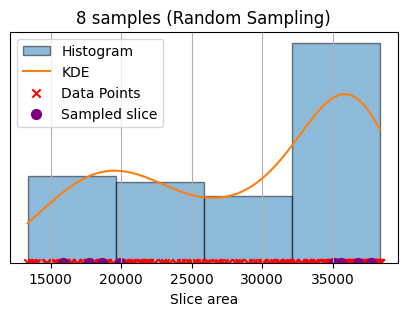

In [24]:
# 提供的数据
data = valid_dic['/ssd2/ming/2024COVID/valid_pure_crop_challenge/negative/ct_scan_1'][2:][0]
# 使用gaussian_kde计算Kernel Density Estimate
kde = gaussian_kde(data)

# 为了绘制KDE, 我们需要一个范围和密度值
x_grid = np.linspace(min(data), max(data), 100)
kde_values = kde.evaluate(x_grid)


data_np = np.array(data)
# 调整抽样策略，使得在数据更密集的区间抽取更多样本，而在稀疏的区间可能不抽取样本
samples_per_bin_adjusted = []
samples_count_per_bin = []

# 指定区间数
k = 4

# 创建k个区间
bins = np.linspace(min(data), max(data), k+1)

# 从data中简单随机抽取16个样本
random_sampled_values = np.random.choice(data_np, 8, replace=False)
random_sampled_values = np.sort(random_sampled_values)  # 排序，以便观察

# 绘制直方图、KDE和简单随机抽样结果
plt.figure(figsize=(5, 3))
plt.hist(data_np, bins=bins, density=True, alpha=0.5, edgecolor='black', label='Histogram')
plt.plot(x_grid, kde_values, label='KDE')
plt.scatter(data_np, np.zeros_like(data_np), color='red', marker='x', label='Data Points')

# 标记简单随机抽样得到的样本点
plt.scatter(random_sampled_values, np.zeros_like(random_sampled_values), color='purple', marker='o', s=50, label='Sampled slice')

plt.gca().get_yaxis().set_visible(False)  # 显示y轴

# 添加图例
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('8 samples (Random Sampling)')
plt.xlabel('Slice area')
plt.ylabel('Density')
plt.grid(True)
plt.show()



[15311. 16056. 19845. 20246. 30869. 34867. 36847. 37718.]
[0, 2, 136, 127, 36, 110, 103, 100]


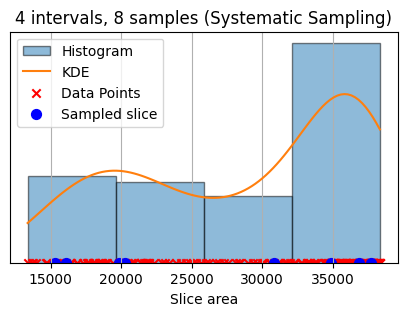

In [94]:
from scipy.stats import gaussian_kde
import numpy as np

# 提供的数据
data = valid_dic['/ssd2/ming/2024COVID/valid_pure_crop_challenge/negative/ct_scan_1'][2:][0]
# 使用gaussian_kde计算Kernel Density Estimate
kde = gaussian_kde(data)

# 为了绘制KDE, 我们需要一个范围和密度值
x_grid = np.linspace(min(data), max(data), 100)
kde_values = kde.evaluate(x_grid)


# 调整抽样策略，使得在数据更密集的区间抽取更多样本，而在稀疏的区间可能不抽取样本
samples_per_bin_adjusted = []
samples_count_per_bin = []

# 指定区间数
k = 4

# 创建k个区间
bins = np.linspace(min(data), max(data), k+1)

# 计算每个区间内的数据点数量
bin_counts = [sum((data >= bins[i]) & (data < bins[i+1])) for i in range(len(bins)-1)]

# 分配样本：每个区间至少一个样本，剩余按比例分配
samples_per_bin = np.ones(k, dtype=int)
remaining_samples = 8 - k  # 减去已分配的样本

# 计算每个区间数据点的比例
proportions = np.array(bin_counts) / sum(bin_counts)

# 根据比例分配剩余样本
additional_samples = np.floor(proportions * remaining_samples).astype(int)
samples_per_bin += additional_samples

# 分配剩余样本（如果有）
remaining_samples -= additional_samples.sum()
while remaining_samples > 0:
    # 按比例选择区间分配剩余样本
    indices = np.argsort(proportions)[::-1][:remaining_samples]
    for i in indices:
        samples_per_bin[i] += 1
        remaining_samples -= 1

data_np = np.array(data)

sampled_values_corrected = []

for i in range(len(bins) - 1):
    bin_data = data_np[(data_np >= bins[i]) & (data_np < bins[i+1])]
    samples_count = samples_per_bin[i]
    
    # 如果区间内的数据点少于要抽取的样本数，则取全部数据点
    if len(bin_data) <= samples_count:
        sampled_values_corrected.extend(bin_data.tolist())
    else:
        # 随机选择区间内指定数量的样本值
        sampled_values_corrected.extend(np.random.choice(bin_data, samples_count, replace=False).tolist())

sampled_values_corrected = np.sort(sampled_values_corrected)  # 对抽取的样本值进行排序，以便观察
print(sampled_values_corrected)

sampled_indices = [np.where(data_np == value)[0][0] for value in sampled_values_corrected]

print(sampled_indices)

# 绘制直方图、KDE和调整后的抽样结果
plt.figure(figsize=(5, 3))
plt.hist(data, bins=bins, density=True, alpha=0.5, edgecolor='black',label='Histogram')

plt.plot(x_grid, kde_values, label='KDE')
plt.scatter(data, np.zeros_like(data), color='red', marker='x', label='Data Points')

# 绘制调整后每个区间抽取的样本
plt.scatter(sampled_values_corrected, np.zeros_like(sampled_values_corrected), color='blue', marker='o', s=50, label='Sampled slice')
plt.gca().get_yaxis().set_visible(False)

# 添加图例（去除重复项）
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('4 intervals, 8 samples (Systematic Sampling)')
plt.xlabel('Slice area')
plt.ylabel('Density')
plt.grid(True)
plt.show()


In [98]:
from scipy.stats import gaussian_kde
import numpy as np
def ss_sampling(area_list,start_index,k,sample):
# 提供的数据
    data = area_list
    # 使用gaussian_kde计算Kernel Density Estimate
    kde = gaussian_kde(data)
    # 为了绘制KDE, 我们需要一个范围和密度值
    x_grid = np.linspace(min(data), max(data), 100)
    kde_values = kde.evaluate(x_grid)
    # 调整抽样策略，使得在数据更密集的区间抽取更多样本，而在稀疏的区间可能不抽取样本
    samples_per_bin_adjusted = []
    samples_count_per_bin = []
    # 指定区间数


    # 创建k个区间
    bins = np.linspace(min(data), max(data), k+1)

    # 计算每个区间内的数据点数量
    bin_counts = [sum((data >= bins[i]) & (data < bins[i+1])) for i in range(len(bins)-1)]

    # 分配样本：每个区间至少一个样本，剩余按比例分配
    samples_per_bin = np.ones(k, dtype=int)
    remaining_samples = sample - k  # 减去已分配的样本

    # 计算每个区间数据点的比例
    proportions = np.array(bin_counts) / sum(bin_counts)

    # 根据比例分配剩余样本
    additional_samples = np.floor(proportions * remaining_samples).astype(int)
    samples_per_bin += additional_samples

    # 分配剩余样本（如果有）
    remaining_samples -= additional_samples.sum()
    while remaining_samples > 0:
        # 按比例选择区间分配剩余样本
        indices = np.argsort(proportions)[::-1][:remaining_samples]
        for i in indices:
            samples_per_bin[i] += 1
            remaining_samples -= 1

    data_np = np.array(data)

    sampled_values_corrected = []

    for i in range(len(bins) - 1):
        bin_data = data_np[(data_np >= bins[i]) & (data_np < bins[i+1])]
        samples_count = samples_per_bin[i]
        
        # 如果区间内的数据点少于要抽取的样本数，则取全部数据点
        if len(bin_data) <= samples_count:
            sampled_values_corrected.extend(bin_data.tolist())
        else:
            # 随机选择区间内指定数量的样本值
            sampled_values_corrected.extend(np.random.choice(bin_data, samples_count, replace=False).tolist())

    sampled_values_corrected = np.sort(sampled_values_corrected)  # 对抽取的样本值进行排序，以便观察
    #print(sampled_values_corrected)

    sampled_indices = [np.where(data_np == value)[0][0] for value in sampled_values_corrected]
    sampled_indices = [x+start_index for x in sampled_indices]
    return sampled_indices

In [165]:
from scipy.integrate import cumtrapz
def kd_sampling(area_list,start_index,k,sample):
# 提供的数据
    data = area_list
    data_np = np.array(data)
    # 使用gaussian_kde计算Kernel Density Estimate
    kde = gaussian_kde(data)
    # 为了绘制KDE, 我们需要一个范围和密度值
    x_grid = np.linspace(min(data), max(data), 100)
    kde_values = kde.evaluate(x_grid)
    # 计算KDE曲线下的面积，以此近似CDF
    cdf = cumtrapz(kde_values, x_grid, initial=0)
    cdf /= cdf[-1]  # 归一化，使得CDF的最大值为1
    # 找出等分的百分位数对应的值作为区间边界
    percentiles = np.linspace(0, 1, k+1)
    bins_percentiles = np.interp(percentiles, cdf, x_grid)

    # 根据新的区间边界进行抽样和绘图过程的剩余部分
    bin_counts_percentiles = [sum((data >= bins_percentiles[i]) & (data < bins_percentiles[i+1])) for i in range(len(bins_percentiles)-1)]
    samples_per_bin_percentiles = np.ones(k, dtype=int)
    remaining_samples_percentiles = sample - k

    proportions_percentiles = np.array(bin_counts_percentiles) / sum(bin_counts_percentiles)
    additional_samples_percentiles = np.floor(proportions_percentiles * remaining_samples_percentiles).astype(int)
    samples_per_bin_percentiles += additional_samples_percentiles

    remaining_samples_percentiles -= additional_samples_percentiles.sum()
    while remaining_samples_percentiles > 0:
        indices_percentiles = np.argsort(proportions_percentiles)[::-1][:remaining_samples_percentiles]
        for i in indices_percentiles:
            samples_per_bin_percentiles[i] += 1
            remaining_samples_percentiles -= 1

    sampled_values_corrected_percentiles = []
    for i in range(len(bins_percentiles) - 1):
        bin_data = data_np[(data_np >= bins_percentiles[i]) & (data_np < bins_percentiles[i+1])]
        samples_count = samples_per_bin_percentiles[i]
        if len(bin_data) <= samples_count:
            sampled_values_corrected_percentiles.extend(bin_data.tolist())
        else:
            sampled_values_corrected_percentiles.extend(np.random.choice(bin_data, samples_count, replace=False).tolist())

    sampled_values_corrected_percentiles = np.sort(sampled_values_corrected_percentiles)
    sampled_indices = [np.where(data_np == value)[0][0] for value in sampled_values_corrected_percentiles]
    sampled_indices = [x+start_index for x in sampled_indices]
    #print(sampled_indices)
    return sampled_indices


[20899. 23308. 24829. 25774. 26710. 27360. 27848. 28166.] [119, 142, 222, 160, 229, 201, 182, 188]


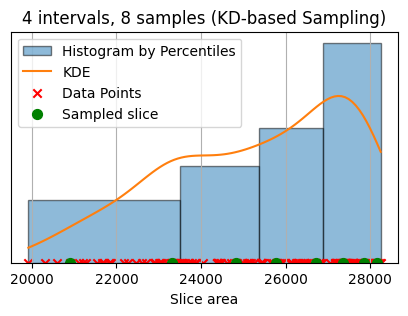

In [164]:
    data = valid_dic['/ssd2/ming/2024COVID/valid_pure_crop_challenge/negative/ct_scan_5'][2:][0]
    data_np = np.array(data)
    # 使用gaussian_kde计算Kernel Density Estimate
    kde = gaussian_kde(data)
    # 为了绘制KDE, 我们需要一个范围和密度值
    x_grid = np.linspace(min(data), max(data), 100)
    kde_values = kde.evaluate(x_grid)
    # 计算KDE曲线下的面积，以此近似CDF
    cdf = cumtrapz(kde_values, x_grid, initial=0)
    cdf /= cdf[-1]  # 归一化，使得CDF的最大值为1
    k=4
    # 找出等分的百分位数对应的值作为区间边界
    percentiles = np.linspace(0, 1, k+1)
    bins_percentiles = np.interp(percentiles, cdf, x_grid)

    # 根据新的区间边界进行抽样和绘图过程的剩余部分
    bin_counts_percentiles = [sum((data >= bins_percentiles[i]) & (data < bins_percentiles[i+1])) for i in range(len(bins_percentiles)-1)]
    samples_per_bin_percentiles = np.ones(k, dtype=int)
    remaining_samples_percentiles = 8 - k

    proportions_percentiles = np.array(bin_counts_percentiles) / sum(bin_counts_percentiles)
    additional_samples_percentiles = np.floor(proportions_percentiles * remaining_samples_percentiles).astype(int)
    samples_per_bin_percentiles += additional_samples_percentiles

    remaining_samples_percentiles -= additional_samples_percentiles.sum()
    while remaining_samples_percentiles > 0:
        indices_percentiles = np.argsort(proportions_percentiles)[::-1][:remaining_samples_percentiles]
        for i in indices_percentiles:
            samples_per_bin_percentiles[i] += 1
            remaining_samples_percentiles -= 1

    sampled_values_corrected_percentiles = []
    for i in range(len(bins_percentiles) - 1):
        bin_data = data_np[(data_np >= bins_percentiles[i]) & (data_np < bins_percentiles[i+1])]
        samples_count = samples_per_bin_percentiles[i]
        if len(bin_data) <= samples_count:
            sampled_values_corrected_percentiles.extend(bin_data.tolist())
        else:
            sampled_values_corrected_percentiles.extend(np.random.choice(bin_data, samples_count, replace=False).tolist())

    sampled_values_corrected_percentiles = np.sort(sampled_values_corrected_percentiles)
    sampled_indices = [np.where(data_np == value)[0][0] for value in sampled_values_corrected_percentiles]

    sampled_indices = [x+116 for x in sampled_indices]

    # 绘制调整后的直方图和KDE
    plt.figure(figsize=(5, 3))
    plt.hist(data_np, bins=bins_percentiles, density=True, alpha=0.5, edgecolor='black', label='Histogram by Percentiles')
    plt.plot(x_grid, kde_values, label='KDE')
    #plt.scatter(sampled_values_corrected_percentiles, np.zeros_like(sampled_values_corrected_percentiles) - 0.01, color='green', marker='o', s=50, label='Sampled by KDE Percentiles')
    plt.gca().get_yaxis().set_visible(False)
    #sampled_values_corrected, np.zeros_like(sampled_values_corrected)
    plt.scatter(data, np.zeros_like(data), color='red', marker='x', label='Data Points')

    plt.scatter(sampled_values_corrected_percentiles, np.zeros_like(sampled_values_corrected), color='green', marker='o', s=50, label='Sampled slice')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    print(sampled_values_corrected_percentiles,sampled_indices)
    plt.title('4 intervals, 8 samples (KD-based Sampling)')
    plt.xlabel('Slice area')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

In [122]:
sampled_values_corrected_percentiles

array([15641., 20591., 23195., 26657., 27266., 29109., 29250., 30573.])

In [66]:
def equal_length_sampling(area_list,start_index,k,sample):

    k = 8
    # 创建k个区间
    bins = np.linspace(min(data), max(data), k+1)
    # 计算每个区间内的数据点数量
    bin_counts = [sum((data >= bins[i]) & (data < bins[i+1])) for i in range(len(bins)-1)]
    # 分配样本：每个区间至少一个样本，剩余按比例分配
    samples_per_bin = np.ones(k, dtype=int)
    remaining_samples = 16 - k  # 减去已分配的样本
    # 计算每个区间数据点的比例
    proportions = np.array(bin_counts) / sum(bin_counts)
    # 根据比例分配剩余样本
    additional_samples = np.floor(proportions * remaining_samples).astype(int)
    samples_per_bin += additional_samples
    # 分配剩余样本（如果有）
    remaining_samples -= additional_samples.sum()
    while remaining_samples > 0:
        # 按比例选择区间分配剩余样本
        indices = np.argsort(proportions)[::-1][:remaining_samples]
        for i in indices:
            samples_per_bin[i] += 1
            remaining_samples -= 1

    data_np = np.array(data)

    sampled_values_corrected = []

    for i in range(len(bins) - 1):
        bin_data = data_np[(data_np >= bins[i]) & (data_np < bins[i+1])]
        samples_count = samples_per_bin[i]
        
        # 如果区间内的数据点少于要抽取的样本数，则取全部数据点
        if len(bin_data) <= samples_count:
            sampled_values_corrected.extend(bin_data.tolist())
        else:
            # 随机选择区间内指定数量的样本值
            sampled_values_corrected.extend(np.random.choice(bin_data, samples_count, replace=False).tolist())

    sampled_values_corrected = np.sort(sampled_values_corrected)  # 对抽取的样本值进行排序，以便观察
    sampled_indices = [np.where(data_np == value)[0][0] for value in sampled_values_corrected]
    sampled_indices = [x+start_index for x in sampled_indices]

    return sampled_indices

[10875. 14091. 17809. 18618. 22248. 23036. 24335. 25296. 26386. 26663.
 27550. 28683. 29364. 29811. 30745. 30872.]
[1, 8, 18, 21, 33, 37, 46, 49, 55, 57, 65, 77, 83, 154, 98, 97]


In [114]:
sampled_indices = [x+116 for x in sampled_indices]
sampled_indices

[119, 126, 135, 140, 149, 163, 184, 254]